# Calculating ground states on large scale systems: Quantum Krylov Subspaces

### Imports and definitions



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

import itertools as it

def solve_regularized_gen_eig(h: np.ndarray, s:np.ndarray, threshold: float, k: int =1, return_dimn: bool = False) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem

    
    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]
        


def single_particle_gs(H_op, n_qubits):
    H_x = []
    for p, coeff in H_op.to_list():
        H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

    H_z = []
    for p, coeff in H_op.to_list():
        H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

    H_c = H_op.coeffs

    print('n_sys_qubits', n_qubits)

    # n_exc particle Hamiltonian:

    n_exc = 1
    sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
    print('n_exc', n_exc, ', subspace dimension', sub_dimn)

    few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

    sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

    m = 0
    for i, i_set in enumerate(sparse_vecs):
        for j, j_set in enumerate(sparse_vecs):
            m += 1
            # if m % int((sub_dimn**2)/100) == 0:
            #     print(np.round(m/int((sub_dimn**2)/100),2), '% complete, time =', time.time()-start_time)
            #     start_time = time.time()

            if len(i_set.symmetric_difference(j_set)) <= 2:

                for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                    if i_set.symmetric_difference(j_set) == p_x:
                        sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                    else:
                        sgn = 0

                    few_particle_H[i,j] += sgn*coeff

    gs_en = min(np.linalg.eigvalsh(few_particle_H))
    print('single particle ground state energy: ', gs_en)
    return gs_en




### Define Hamiltonian

Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H= J \sum_{i,j}^N X_i X_j + Y_i Y_j - Z_i Z_j$

In [2]:
# Define problem Hamiltonian.
n_qubits = 8
J = 1 # coupling strength for ZZ interaction

# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIIIII', -1), ('IZZIIIII', -1), ('IIZZIIII', -1), ('IIIZZIII', -1), ('IIIIZZII', -1), ('IIIIIZZI', -1), ('IIIIIIZZ', -1), ('XXIIIIII', 1), ('IXXIIIII', 1), ('IIXXIIII', 1), ('IIIXXIII', 1), ('IIIIXXII', 1), ('IIIIIXXI', 1), ('IIIIIIXX', 1), ('YYIIIIII', 1), ('IYYIIIII', 1), ('IIYYIIII', 1), ('IIIYYIII', 1), ('IIIIYYII', 1), ('IIIIIYYI', 1), ('IIIIIIYY', 1)]


Heuristically choose `dt` (based on upper bounds)

In [3]:
from qiskit.quantum_info import Pauli
# Get Hamiltonian restricted to single-particle states
single_particle_H = np.zeros((n_qubits,n_qubits))
for i in range(n_qubits):
    for j in range(i+1):
        for p, coeff in H_op.to_list():
            p_x = Pauli(p).x
            p_z = Pauli(p).z
            if all(p_x[k] == ((i==k)+(j==k))%2 for k in range(n_qubits)):
                sgn = ((-1j)**sum(p_z[k] and p_x[k] for k in range(n_qubits)))*((-1)**p_z[i])
            else:
                sgn = 0
            single_particle_H[i,j] += sgn*coeff
for i in range(n_qubits):
    for j in range(i+1,n_qubits):
        single_particle_H[i,j] = np.conj(single_particle_H[j,i])

# Set dt according to spectral norm
dt = np.pi/np.linalg.norm(single_particle_H, ord=2)
dt

0.44879895051282764

### Set parameters for the algorithm

In [4]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 20 # size of krylov subspace
num_trotter_steps = 6
dt_circ = dt/num_trotter_steps

### Decompose time-evolution operator with Suzuki-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Suzuki-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY + ZZ) t}$. This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality. 

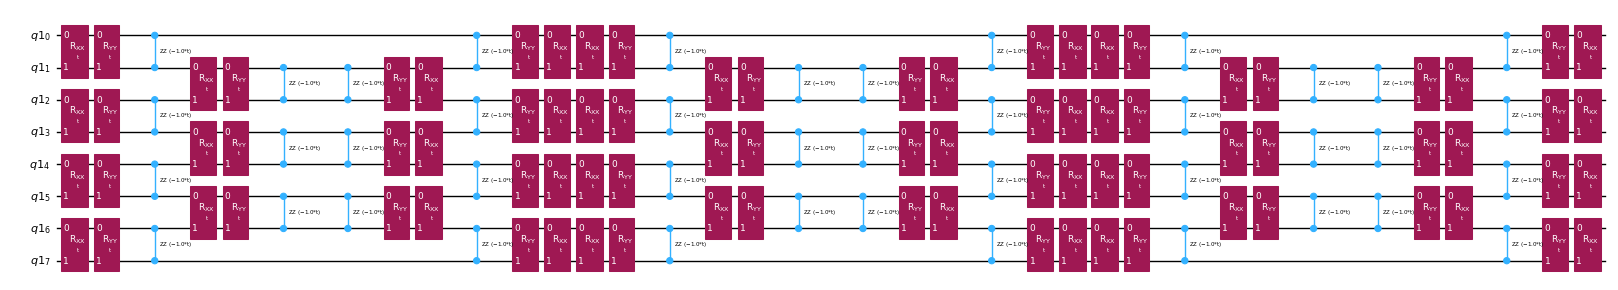

In [5]:
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t,0,1)
Rxyz_circ.ryy(t,0,1)
Rxyz_circ.rzz(-t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(num_trotter_steps):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        qc_evol = qc_evol.compose(reverse_trotter_step_circ)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)



### Use an optimized circuit for state preparation

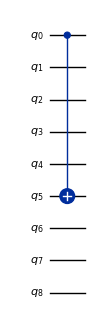

In [6]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(0,int(n_qubits/2)+1)
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ and $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.

In [7]:
# Parameters for the template circuits
parameters = []
for idx_ket in range(1, krylov_dim):
    parameters.append(dt_circ*(idx_ket))

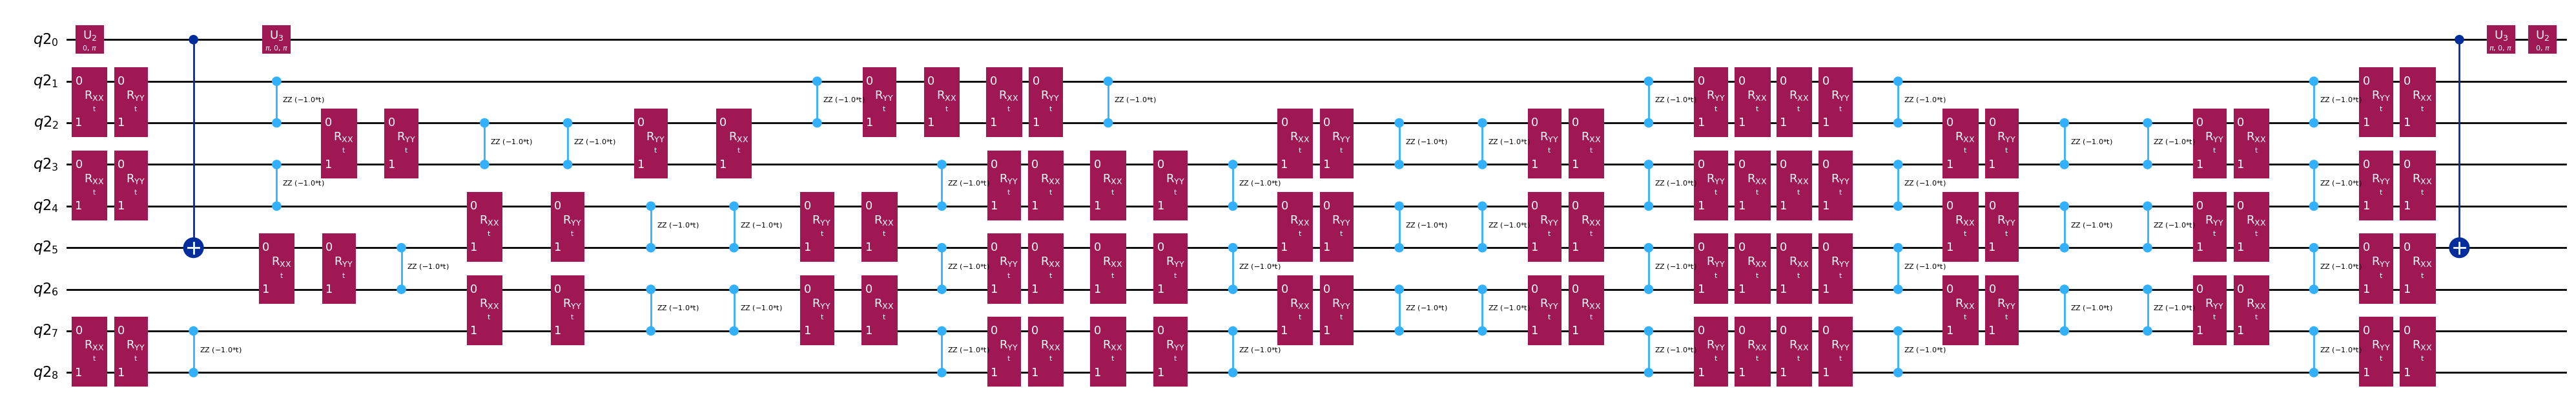

In [8]:
# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_real.barrier()
qc_real.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_real.barrier()
qc_real.x(0)
qc_real.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real.x(0)
qc_real.h(0)

S_real_circ = qc_real.decompose().copy()

H_real_circ = qc_real.decompose().copy()

# # Create hadamard test circuit for imaginary part
qr = QuantumRegister(n_qubits+1)
qc_imag = QuantumCircuit(qr)
qc_imag.h(0)
qc_imag.sdg(0)
qc_imag.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_imag.barrier()
qc_imag.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_imag.barrier()
qc_imag.x(0)
qc_imag.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag.x(0)
qc_imag.h(0)


S_imag_circ = qc_imag.decompose().copy()

H_imag_circ = qc_imag.decompose().copy()

S_real_circ.draw('mpl', fold=-1)

## Step 3: Execute using a quantum primitive

Instantiate the backend and set runtime parameters

In [34]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeGuadalupeV2
from qiskit_aer import AerSimulator


SIM = True
NOISE = False
# service = QiskitRuntimeService(instance='ibm-q-internal/technical-enable/utokyol3enableme')#
# service = QiskitRuntimeService(instance='quantum-demonstrations/main/krylov-gs')
service = QiskitRuntimeService(instance='grants/qciss/main')



if SIM:
    # backend = service.least_busy(simulator=True)
    
    if NOISE:
        backend = AerSimulator.from_backend(FakeGuadalupeV2(), seed_simulator=42)

    else:
        backend = AerSimulator()

else:
    backend_id = 'ibm_pinguino1'
    # backend_id = 'ibm_torino'
    backend = service.backend(backend_id)

shots = 300000


RequestsApiError: "HTTPSConnectionPool(host='api-qcon.quantum.ibm.com', port=443): Max retries exceeded with url: /api/Network (Caused by ResponseError('too many 503 error responses'))"

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeGuadalupeV2
from qiskit_aer import AerSimulator


SIM = True
NOISE = False


backend = AerSimulator()

shots = 300000



In [11]:
# from qiskit_ibm_provider import IBMProvider
# from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch


# SIM = False
# NOISE = False

# # IBMQ.load_account()
# provider = IBMProvider(name="staging")
# backend = provider.get_backend('ibm_montecarlo')
# shots = 300000


### Transpile + schedule with DD

In [12]:
from qiskit.circuit.library import XGate, YGate, RZGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

if not SIM:


    target = backend.target
    basis_gates = list(target.operation_names)


    X = XGate()
    Y = YGate()
    
    # dd_sequence = [X, X, X, X]

    dd_sequence=[XGate(), RZGate(np.pi), XGate(), RZGate(-np.pi)]
    spacing = [1 / 4, 1 / 2, 0, 0, 1 / 4]


    
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update(
            {
                (qubit,): InstructionProperties(
                    duration=target["x"][(qubit,)].duration,
                    error=target["x"][(qubit,)].error,
                )
            }
        )
    if 'y' not in target.operation_names:
        target.add_instruction(YGate(), y_gate_properties)

    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)


    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence, spacing=spacing),
        ]
    )

    S_real_circ_trans = pm.run(S_real_circ)
    S_imag_circ_trans = pm.run(S_imag_circ)

    H_real_circ_trans = pm.run(H_real_circ)
    H_imag_circ_trans = pm.run(H_imag_circ)

elif SIM and NOISE:
    target = backend.target
    basis_gates = list(target.operation_names)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)

    S_real_circ_trans = pm.run(S_real_circ)
    S_imag_circ_trans = pm.run(S_imag_circ)

    H_real_circ_trans = pm.run(H_real_circ)
    H_imag_circ_trans = pm.run(H_imag_circ)


In [13]:
# S_real_circ_trans.draw('mpl', fold=-1, idle_wires=False, scale=0.5)
# S_real_circ_trans.depth(lambda x: x[0].num_qubits==2)
# S_real_circ_trans.count_ops()['cz']

In [14]:
# from qiskit.visualization import timeline_drawer
# from qiskit.transpiler.passes.scheduling import ALAPSchedule
# from qiskit.transpiler import PassManager, InstructionDurations

# b_circ = S_real_circ_trans_dd.assign_parameters({t:1})
# durations = InstructionDurations().from_backend(backend)
# pm = PassManager([ALAPSchedule(durations=durations)])
# sched_circ = pm.run(b_circ)

# timeline_drawer(sched_circ, show_idle=False)
# # timeline_drawer(b_circ)

In [15]:
# Define observables to measure for S
observable = 'I'*(n_qubits) + 'Z'

if not SIM or (SIM and NOISE):

    layout = S_real_circ_trans.layout

    observable_op = SparsePauliOp(observable)
    observable_op = observable_op.apply_layout(layout)
    observable = observable_op.paulis.to_labels()


# Define a set of observables to measure
else:
    observable = ['I'*(n_qubits) + 'Z']

observables_S = [observable]

# Define a sweep over parameter values
params = np.vstack(parameters).T

# Estimate the expectation value for all combinations of
# observables and parameter values, where the pub result will have
# shape (# observables, # parameter values).

if not SIM or (SIM and NOISE):
    pub_S_real = (S_real_circ_trans, observables_S, params)
    pub_S_imag = (S_imag_circ_trans, observables_S, params)
else:
    pub_S_real = (S_real_circ, observables_S, params)
    pub_S_imag = (S_imag_circ, observables_S, params)



# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable = pauli[::-1].to_label() + 'Z'
    observable_list.append([observable])


if not SIM or (SIM and NOISE):

    layout = H_real_circ_trans.layout

    observable_trans_list = []
    for observable in observable_list:
        observable_op = SparsePauliOp(observable)
        observable_op = observable_op.apply_layout(layout)
        observable_trans_list.append(observable_op.paulis.to_labels())

    observable_list = observable_trans_list


observables_H = observable_list



if not SIM or (SIM and NOISE):
    pub_H_real = (H_real_circ_trans, observables_H, params)
    pub_H_imag = (H_imag_circ_trans, observables_H, params)
else:
    pub_H_real = (H_real_circ, observables_H, params)
    pub_H_imag = (H_imag_circ, observables_H, params)


## Run circuits

Circuits for $t=0$ are classically calculable

In [16]:
from qiskit.quantum_info import StabilizerState, Pauli



H_real_circ_cliff = H_real_circ.assign_parameters({t:0})
H_imag_circ_cliff = H_imag_circ.assign_parameters({t:0})
S_real_circ_cliff = S_real_circ.assign_parameters({t:0})
S_imag_circ_cliff = S_imag_circ.assign_parameters({t:0})

observables_S_cliff = 'I'*(n_qubits) + 'Z'

observables_H_cliff = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable = pauli[::-1].to_label() + 'Z'
    observables_H_cliff.append(observable)



# Get expectation values from experiment
S_expval_real = StabilizerState(S_real_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))
S_expval_imag = StabilizerState(S_imag_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))

# Get expectation values
S_expval = S_expval_real + 1j*S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(H_real_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
    expval_imag = StabilizerState(H_imag_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
    expval = expval_real + 1j*expval_imag


    # Fill-in matrix elements
    H_expval += coeff*expval


H_expval

(-3+0j)

Execute circuits for $\tilde{S}$ and $\tilde{H}$ with the Estimator

In [17]:
shots = 300000

In [18]:
if SIM:
    with Session(backend=backend) as session:
        estimator = Estimator(session=session)
        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))

else:
    with Batch(backend=backend) as batch:

        estimator = Estimator(session=batch, options={"resilience_level": 1, "experimental": {"execution": {"fast_parametric_update" : False}}})

        # estimator.options.resilience.zne_mitigation=True
        # estimator.options.resilience.zne.extrapolator='linear'
        # estimator.options.resilience.zne.noise_factors = [1,1.3,1.6]

        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))


In [19]:
job_S_real_id = job_S_real.job_id()
job_S_imag_id = job_S_imag.job_id()
job_H_real_id = job_H_real.job_id()
job_H_imag_id = job_H_imag.job_id()
print(job_S_real_id)
print(job_S_imag_id)
print(job_H_real_id)
print(job_H_imag_id)


93d5be62-d2e1-4e78-acba-786d25c6a781
421c2e29-29b0-4fd9-bc1f-c4a9b4afbddd
427a8abb-a233-4217-8f67-9e1ec0416688
85bdfd66-77b1-44e5-8ae3-bec5db79cc07


## Step 4: Post-process and analyze results

In [20]:
S_real_results = job_S_real.result()[0]
S_imag_results = job_S_imag.result()[0]
H_real_results = job_H_real.result()[0]
H_imag_results = job_H_imag.result()[0]

In [21]:
prefactors = []
E0t_array = []
for i, circ in enumerate(iter(qc_evol.assign_parameters([(i*dt)/num_trotter_steps]) for i in range(1, krylov_dim))):
    phase = 1.0
    E0t = 0
    for instruction in circ.data:
        if instruction.operation.name != 'swap' and instruction.operation.name != 'barrier':
            # All the non-swap gates are XX+YY+ZZ rotations, which add a phase to the all-zeros state.
            if instruction.operation.params:
                E0t += float(instruction.operation.params[0])
                # phase *= np.exp(1j*float(instruction.operation.params[0])/2)
                phase *= np.exp(-1j*float(instruction.operation.params[0])/2) # NY added, we need to `subtract` the E0 * t so minus sign
            # assert(float(instruction.operation.params[0]._symbol_expr) == i*dt/n_T_step)
    prefactors.append(phase)

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [22]:
import itertools
# Assemble S, the overlap matrix of dimension D:
S_first_row = np.zeros(krylov_dim, dtype=complex)
S_first_row[0] = 1+0j

# Add in ancilla-only measurements:
for i in range(krylov_dim-1):

    # Get expectation values from experiment
    expval_real = S_real_results.data.evs[0][i]
    expval_imag = S_imag_results.data.evs[0][i]

    # Get expectation values
    expval = expval_real + 1j*expval_imag
    # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
    S_first_row[i+1] += prefactors[i]*expval

S_first_row_list =  S_first_row.tolist() #for saving purposes     
            
            
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ[j,i] = S_first_row[i-j]
    else:
        S_circ[j,i] = np.conj(S_first_row[j-i])

In [23]:
from sympy import Matrix
Matrix(S_circ)

Matrix([
[                                        1.0,    -0.631026666666665 - 0.503986666666665*I,               0.07808 + 0.338266666666666*I,             -0.0555666666666667 + 0.10774*I,               0.328959999999999 - 0.15402*I,    -0.288093333333334 - 0.086293333333333*I, -0.00754666666666662 + 0.0816066666666667*I,     0.122133333333334 + 0.156026666666667*I,   -0.0423933333333335 - 0.301253333333333*I,             -0.0426333333333333 + 0.35758*I,     0.215286666666665 - 0.404986666666668*I,    -0.483466666666667 + 0.214686666666668*I,     0.497380000000001 + 0.233393333333333*I,    -0.136706666666668 - 0.502766666666667*I,    -0.154653333333333 + 0.363473333333333*I,     0.104953333333332 - 0.223140000000001*I,   -0.0534266666666668 + 0.322666666666667*I,     0.205939999999998 - 0.302013333333334*I,   -0.122013333333333 + 0.0405133333333339*I,   -0.338633333333334 - 0.0778533333333314*I],
[   -0.631026666666665 + 0.503986666666665*I,                                         1.0

And the matrix elements of $\tilde{H}$

In [24]:
import itertools
# Assemble S, the overlap matrix of dimension D:
H_first_row = np.zeros(krylov_dim, dtype=complex)
H_first_row[0] = H_expval

for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Add in ancilla-only measurements:
    for i in range(krylov_dim-1):

        # Get expectation values from experiment
        expval_real = H_real_results.data.evs[obs_idx][i]
        expval_imag = H_imag_results.data.evs[obs_idx][i]

        # Get expectation values
        expval = expval_real + 1j*expval_imag
        # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
        H_first_row[i+1] += prefactors[i]*coeff*expval
        
H_first_row_list = H_first_row.tolist()           
            
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ[j,i] = H_first_row[i-j]
    else:
        H_eff_circ[j,i] = np.conj(H_first_row[j-i])





In [25]:
from sympy import Matrix
Matrix(H_eff_circ)

Matrix([
[                                    -3.0,   0.886573333333332 + 2.77099999999999*I,    2.02173333333333 - 1.53524666666666*I,   -1.43129333333334 - 1.10206666666667*I, -0.817693333333332 + 0.902586666666665*I,            0.800340000000004 + 1.00524*I,            0.794026666666667 - 1.14632*I, -1.08749333333333 - 0.0446733333333324*I,  0.494753333333332 + 0.365373333333332*I,           -0.601066666666667 - 0.41964*I,   0.381593333333338 + 1.39254666666667*I,             1.29328 - 1.64427333333334*I,  -2.30539333333334 - 0.033713333333329*I,                       1.12982 + 1.3811*I, 0.0316333333333325 - 0.692033333333332*I,           0.59554 - 0.0706333333333366*I,  -1.08669333333334 - 0.794173333333335*I,            -0.064279999999994 + 1.2159*I,            0.51626 + 0.181746666666664*I,   1.21913333333333 - 0.688620000000008*I],
[  0.886573333333332 - 2.77099999999999*I,                                     -3.0,   0.886573333333332 + 2.77099999999999*I,    2.02173333333333 - 

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [26]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=5e-1)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  -3.0
The estimated ground state energy is:  -2.9995936564287797
The estimated ground state energy is:  -5.625846734831274
The estimated ground state energy is:  -5.495891690706531
The estimated ground state energy is:  -5.372245756646029
The estimated ground state energy is:  -6.171225880485815
The estimated ground state energy is:  -6.0632564799028135
The estimated ground state energy is:  -5.949123344276864
The estimated ground state energy is:  -6.501822373353083
The estimated ground state energy is:  -6.477334813844601
The estimated ground state energy is:  -6.571921307658908
The estimated ground state energy is:  -7.035875984053212
The estimated ground state energy is:  -7.122209944672355
The estimated ground state energy is:  -7.113848462865043
The estimated ground state energy is:  -7.038485972752604
The estimated ground state energy is:  -6.999804050640894
The estimated ground state energy is:  -7.003886288655714
The estimated ground state

In [27]:
gs_en = min(sp.sparse.linalg.eigsh(H_op.to_matrix(), which = "SA", k = 10)[0])
print('gs_en', gs_en)


gs_en -6.999999999999951


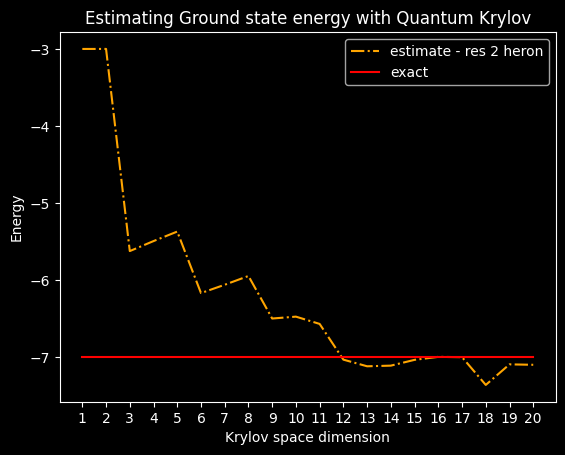

In [28]:
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_0, color = 'blue', linestyle='-.' , label = 'estimate - res 0 ')
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_1, color = 'yellow', linestyle='-.' , label = 'estimate - res 1 ')
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_2, color = 'green', linestyle='-.' , label = 'estimate - res 2')
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'orange', linestyle='-.' , label = 'estimate - res 2 heron')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

#### Numerics

In [29]:
import itertools    

U = sp.linalg.expm(-1j*H_op.to_matrix()*dt) # time-evolution operator

## Start from a random state |psi_0> as the reference state for the unitary krylov subspace
init = np.random.uniform(0, 1, size = 2**n_qubits)*(1+0j)
norm_init = np.linalg.norm(init)
init = init/np.sqrt(norm_init)


# Get different powers of U
u_krylov_ops = [np.eye(2**n_qubits, dtype=complex)]
op = u_krylov_ops[0]
for i in range(1, krylov_dim):
    op = op @ U
    u_krylov_ops.append(op)

# Get vectors of the Krylov subspace
u_krylov_vecs = [op @ init for op in u_krylov_ops]

# Calculate the overlap matrix <psi_i|psi_j> where |psi_i> = U^i |psi_0>
S_first_row = []
for i in range(krylov_dim):
    s = u_krylov_vecs[0].T.conj() @ u_krylov_vecs[i]
    S_first_row.append(s)
print(S_first_row)

# Calculate the expectation values of H in the subspace <psi_i|H|psi_j>
H_first_row = []
for i in range(krylov_dim):
    h = u_krylov_vecs[0].T.conj()@ H_op.to_matrix() @ u_krylov_vecs[i]
    H_first_row.append(h)
print(H_first_row)


S = np.zeros((krylov_dim, krylov_dim), dtype=complex)
# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S[j,i] = S_first_row[i-j]
    else:
        S[j,i] = np.conj(S_first_row[j-i])


H_eff = np.zeros((krylov_dim, krylov_dim), dtype=complex)
# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff[j,i] = H_first_row[i-j]
    else:
        H_eff[j,i] = np.conj(H_first_row[j-i])

[(9.460215263208777+0j), (0.422454100506098+0.8250774251629399j), (1.6127083589759168-0.3119005950866599j), (-1.4308827872925605+1.3817656348351472j), (-0.5381041869678564-1.4175286192063927j), (-1.0718376182971738+0.4141517423936597j), (2.5728358363626613-1.68881548804276j), (0.3294272775390604+1.8464527424495367j), (0.5204023835990333+1.2304264175691522j), (-1.6587544511067822+2.931675195361429j), (-1.291715520156583-0.2274571656923199j), (-2.167752502490295+1.0150732796380388j), (-0.4567392949082064-3.226469085014268j), (-0.08064883528137046+2.336214485957573j), (-0.03894143309329243-0.7732260116317873j), (0.7493311154815732+2.4716031527365816j), (-4.065595841960592+0.8780812052133805j), (0.5193094786149715-0.9013909436454419j), (-2.431783608208714-3.3655007996566226j), (0.09944679002240873-1.0250441515525737j)]
[(51.78315805310111+0j), (7.4922586062659065+13.696718975204892j), (13.833261576732998+15.51882193399473j), (-12.703841716758411+20.72920793751972j), (-6.367326141288017-8.7

In [33]:
# Estimate ground state with increasing number of vector in the subspace (up to the number define at the beginning)
gnd_en_num_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff[:d, :d], S[:d, :d], threshold=1e-10)
    gnd_en_num_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  5.473782214500789
The estimated ground state energy is:  4.238609193499602
The estimated ground state energy is:  2.98812868538964
The estimated ground state energy is:  2.695865375358481
The estimated ground state energy is:  2.047857302169425
The estimated ground state energy is:  1.4671268705674503
The estimated ground state energy is:  0.5859878307603354
The estimated ground state energy is:  -0.2963742228943081
The estimated ground state energy is:  -0.879836952988974
The estimated ground state energy is:  -1.4724708651928549
The estimated ground state energy is:  -2.0739711645641914
The estimated ground state energy is:  -2.352955551340769
The estimated ground state energy is:  -2.426679623785327
The estimated ground state energy is:  -2.519854173593857
The estimated ground state energy is:  -2.648705256457765
The estimated ground state energy is:  -2.8398028117837684
The estimated ground state energy is:  -2.955660180730655
The estimated gr

### Check Paulis

#### Theory calculation (phase issue with real expvals)

In [ ]:
# THIS FUNCTION CALCULATES THE PAULI MATRICES FOR EACH DIMENSION IN d_list, USING NOBU'S k-PARTICLE CODE
# Note that passing in vectors_kp is optional but if you already have it from the Krylov matrix calculation, it can save time.
from utils_k_particle import compute_pauli_matrices
from utils_k_particle import get_indexes_for_m_particles, k_particle_excitation, simulate_unitary_kparticle_from_interaction_list

fixed_control = 0
excitations = [int(n_qubits/2)+1]
H = H_op     

k = len(excitations)
indices = get_indexes_for_m_particles(n_qubits, k)

initial_state_kp = k_particle_excitation(n_qubits, excitations, indices)
vectors_kp = [simulate_unitary_kparticle_from_interaction_list(interaction_list, initial_state_kp, n_qubits, k, num_trotter_steps, param = (i*dt)/num_trotter_steps, as_sparse = True) for i in range(krylov_dim)]

all_exp_vals, vectors_kp = compute_pauli_matrices(n_qubits, fixed_control, excitations, H, interaction_list, num_trotter_steps, dt, list(range(krylov_dim)), vectors_kp)



H_first_row_exact = np.zeros(krylov_dim, dtype=complex)
prefactors_exact = [1+0j] + prefactors
for i, expvals_dict in enumerate(all_exp_vals):


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        expval_real = expvals_dict[new_obs + 'X']
        expval_imag = expvals_dict[new_obs + 'Y']


        expval = expval_real + 1j*expval_imag

        H_first_row_exact[i] += prefactors_exact[i]*coeff*expval



H_first_row_exact_list = H_first_row_exact.tolist()           
            
H_eff_circ_exact = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_exact[j,i] = H_first_row_exact[i-j]
    else:
        H_eff_circ_exact[j,i] = np.conj(H_first_row_exact[j-i])

In [ ]:
Matrix(H_eff_circ_exact)

#### Numerical calculation (few qubits only!)

In [ ]:
from qiskit.quantum_info import Statevector, Pauli

H_first_row_sim = np.zeros(krylov_dim, dtype=complex)
H_first_row_sim[0] = H_expval

S_first_row_sim = np.zeros(krylov_dim, dtype=complex)
S_first_row_sim[0] = 1+0j

all_exp_vals_sim = []
for i, param in enumerate(parameters):

    H_real_circ_cliff = H_real_circ.assign_parameters({t:param})
    H_imag_circ_cliff = H_imag_circ.assign_parameters({t:param})
    S_real_circ_cliff = S_real_circ.assign_parameters({t:param})
    S_imag_circ_cliff = S_imag_circ.assign_parameters({t:param})

    observables_S_cliff = 'I'*(n_qubits) + 'Z'

    observables_H_cliff = []
    for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
        # print(pauli)
        observable = pauli[::-1].to_label() + 'Z'
        observables_H_cliff.append(observable)



    # Get expectation values from experiment
    S_expval_real = Statevector(S_real_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))
    S_expval_imag = Statevector(S_imag_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))

    # Get expectation values
    S_expval = S_expval_real + 1j*S_expval_imag

    S_first_row_sim[i+1] += prefactors[i]*S_expval


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = Statevector(H_real_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
        expval_imag = Statevector(H_imag_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        res_dict_sim[new_obs + 'X'] = expval_real
        res_dict_sim[new_obs + 'Y'] = expval_imag


        expval = expval_real + 1j*expval_imag


        H_first_row_sim[i+1] += prefactors[i]*coeff*expval

    all_exp_vals_sim.append(res_dict_sim)


H_first_row_sim_list = H_first_row_sim.tolist()           
            
H_eff_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_sim[j,i] = H_first_row_sim[i-j]
    else:
        H_eff_circ_sim[j,i] = np.conj(H_first_row_sim[j-i])

            
            
S_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ_sim[j,i] = S_first_row_sim[i-j]
    else:
        S_circ_sim[j,i] = np.conj(S_first_row_sim[j-i])


In [ ]:
gnd_en_circ_sim_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_sim[:d, :d], S_circ_sim[:d, :d], threshold=4e-2)
    gnd_en_circ_sim_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

In [ ]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'orange', linestyle='-.' , label = 'estimate - res 1 heron')
plt.plot(range(1, krylov_dim+1), gnd_en_circ_sim_est_list, color = 'blue', linestyle='-.' , label = 'estimate - sim')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

#### Experimental values

In [ ]:
all_exp_vals_exp = []
for idx in range(krylov_dim-1):
    res_dict = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = H_real_results.data.evs[obs_idx][idx]
        expval_imag = H_imag_results.data.evs[obs_idx][idx]
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        res_dict[new_obs + 'X'] = expval_real
        res_dict[new_obs + 'Y'] = expval_imag
    all_exp_vals_exp.append(res_dict)



#### Compare

In [ ]:
idx  = 6
for pauli, val in all_exp_vals_exp[idx].items():
    
    # if pauli[-1] == 'X' and abs(np.round(phase_factor.real, 2)) > 0:
    #     all_exp_vals[idx+1][pauli] = phase_factor.real*all_exp_vals[idx+1][pauli]
    # if pauli[-1] == 'Y' and abs(np.round(phase_factor.imag, 2)) > 0:
    #     all_exp_vals[idx+1][pauli] = phase_factor.imag*all_exp_vals[idx+1][pauli]


    print(pauli, np.round(val, 3), np.round(all_exp_vals_sim[idx][pauli],3), np.round(all_exp_vals[idx+1][pauli], 3))

In [ ]:
idx  = 0
for pauli, val in all_exp_vals_exp[idx].items():
    if abs(val) > 0.1:
        damp_sim = abs(val/all_exp_vals_sim[idx][pauli])
        damp_ex = abs(val/all_exp_vals[idx+1][pauli])
        print(pauli, np.round(damp_sim, 3), np.round(damp_ex,3))

### Save data

In [ ]:
import os
import pickle
import time

time_string = time.strftime("%m%d%Y_%H%M%S")
data_dir_path = f'data/{backend_id}_{n_qubits}q_{time_string}/'
# Save experiment parameters
var_dict = {k: globals()[k] for k in [ 'n_qubits',
                                        'J',
                                        'H_tot',
                                        'dt',
                                        'krylov_dim',
                                        'num_trotter_steps',
                                        'dt_circ',
                                        'parameters',
                                        'backend_id',
                                        'shots',
                                        'observables_S',
                                        'observables_H',
                                        'pub_S_real',
                                        'pub_S_imag',
                                        'pub_H_real',
                                        'pub_H_imag',
                                        'job_S_real_id',
                                        'job_S_imag_id',
                                        'job_H_real_id',
                                        'job_H_imag_id',
                                        'S_expval',
                                        'H_expval',
                                        'prefactors',
                                        'S_first_row_list',
                                        'H_first_row_list',
                                        'n_exc',
                                        'gs_en',]}



# Save to Box folder (avoid Github large file storage issues)
os.makedirs(os.path.dirname(data_dir_path), exist_ok=True)
fname = data_dir_path + "experiment_parameters.pickle"
with open(fname, "wb") as f:
    pickle.dump(var_dict, f)


np.save(data_dir_path + 'S_real_results_evs', S_real_results.data.evs)
np.save(data_dir_path + 'S_imag_results_evs', S_imag_results.data.evs)
np.save(data_dir_path + 'H_real_results_evs', H_real_results.data.evs)
np.save(data_dir_path + 'H_imag_results_evs', H_imag_results.data.evs)

np.save(data_dir_path + 'S_real_results_metadata', S_real_results.metadata)
np.save(data_dir_path + 'S_imag_results_metadata', S_imag_results.metadata)
np.save(data_dir_path + 'H_real_results_metadata', H_real_results.metadata)
np.save(data_dir_path + 'H_imag_results_metadata', H_imag_results.metadata)